<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_04_ops_case_e2e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#End to end causal case: Compensation and retention

## Business question
Does issuing compensation after an order with an issue ausally imrove 28-day customer retention?

## Decision context
Compensation is costly. Leadership needs to decide wether increasing compensation issuance is likely to improve retention enough to justify the cost

#Outcome
28-day retention (binary or continuous proxy)

#Treatment
Compensation issued after an order issue

## Causal Assumptions
- order issue severity affects both the compensation issuance and the retention
- compensation may affect retention
- some drivers of retention (eg custoemr sentiment) are unobserved
- delivery status occurs after compensation and should not be conditioned on

In [6]:
# Simulate realistic data

import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(7)
n = 5000

#Observed severity
severity = np.random.normal(0, 1, n)

#Unobserved customer sentiment
sentiment = np.random.normal(0, 1, n)

#compensation decision
comp = (
    1.2 * severity
    + 1.0 * sentiment
    + np.random.normal(0, 1, n) # noise
) > 0

comp = comp.astype(int)

#retention outcome
retention = (
    1.5 * comp
    - 2.0 * severity
    + 1.0 * sentiment
    + np.random.normal(0, 1, n)
)

df = pd.DataFrame({
    "retention": retention,
    "comp": comp,
    "severity": severity,
    "sentiment": sentiment
})

#in this world, the true causal effect of compensation is positive but confounded

In [3]:
#naive analysis

naive_model = sm.OLS(
    df["retention"],
    sm.add_constant(df[["comp"]]) #ignoring confounder
).fit()

naive_model.params

# coeff on comp ~0.3 , biases downward (true effect is 1.5)

,0
const,0.638049
comp,0.296599


In [4]:
#adjusted for confounding
adj_model = sm.OLS(
    df["retention"],
    sm.add_constant(df[["comp", "severity"]])
).fit()

adj_model.params

#results: coeff on comp ~2.6 --> best causal estimate under adjustment

,0
const,-0.591996
comp,2.691727
severity,-2.306015


In [11]:
#sensitivity analysis

effects = []
strengths = np.linspace(0, 2, 15)

for s in strengths:
  y_alt = (
      1.5 * df["comp"]
      - 2.0 * df["severity"]
      + s * df["sentiment"]
      + np.random.normal(0, 1, n)
  )
  res = sm.OLS(y_alt, sm.add_constant(df[["comp", "severity"]])).fit()
  effects.append(res.params[1])

/tmp/ipython-input-41576394.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effects.append(res.params[1])
/tmp/ipython-input-41576394.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effects.append(res.params[1])
/tmp/ipython-input-41576394.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effects.append(res.params[1])
/tmp/ipython-input-41576394.py:14: FutureWarning: Series.__getitem__ treating keys as positions is depr

Text(0, 0.5, 'effect on retention')

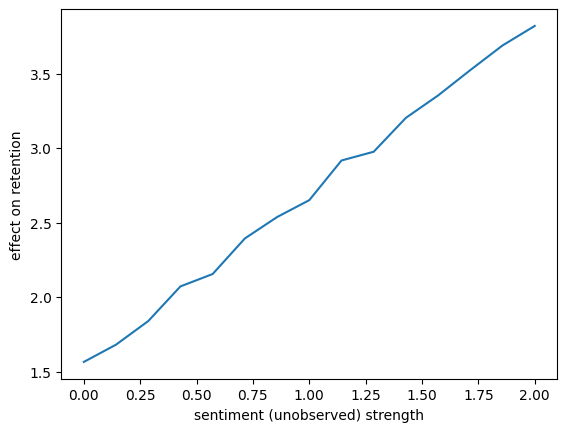

In [12]:
import matplotlib.pyplot as plt

plt.plot(strengths, effects)
plt.xlabel("sentiment (unobserved) strength")
plt.ylabel("effect on retention")

# the unobserved confounder "sentiment" reinforces the causal effect  by adding more confounding (it increases both the probability of compensation and the retention)
# this plot says: if the estimate is wrong, the effect is even bigger
# this test  does not provide me with more useful info, it's not the test I want



In [18]:
#to test correctlym we would need adversarial confounding: something that increases compensation amount/likelihood but decreases retention
#this kind of effect can hide a true null oa a true negative effect
# for instance, switch sentiment for high maintenance customers, latent dissatisfaction, complaint intensity
# these custoemrs are more likely to receive comp but less likely to be retained

#interpret sentiment as "demanding/intense customer "

effects = []
strengths = np.linspace(0, 2, 20)

for s in strengths:
  y_alt = (
      1.5 * df["comp"]
      - 2.0 * df["severity"]
      - s * df["sentiment"] # adversarial confounding
      + np.random.normal(0, 1, n)
  )
  res = sm.OLS(y_alt, sm.add_constant(df[["comp", "severity"]])).fit()
  effects.append(res.params[1])

/tmp/ipython-input-3834608628.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effects.append(res.params[1])
/tmp/ipython-input-3834608628.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effects.append(res.params[1])
/tmp/ipython-input-3834608628.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  effects.append(res.params[1])
/tmp/ipython-input-3834608628.py:19: FutureWarning: Series.__getitem__ treating keys as positions

Text(0, 0.5, 'effect on retention')

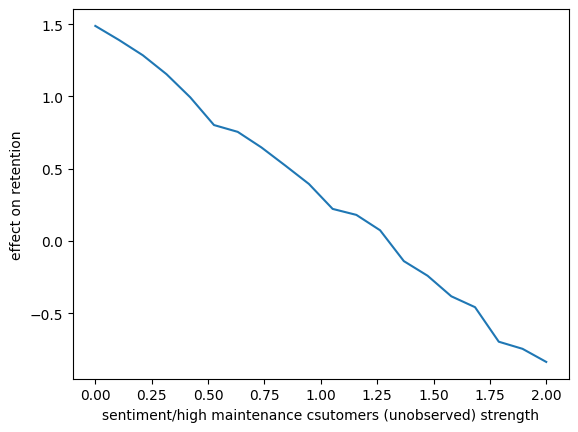

In [19]:
import matplotlib.pyplot as plt

plt.plot(strengths, effects)
plt.xlabel("sentiment/high maintenance csutomers (unobserved) strength")
plt.ylabel("effect on retention")

###Interpretation:
- the effect stays positive until s ~ 1.25
- the unobserved confounding would need to be as strong as severity (observed) to change the conclusion --> that's good enough
- if it were small for instance ~0.3, the result would be quite fragile

###Decision-making insight:
Sensitivity anlaysis weas conducted under adversarial assumptions in which unobserved confounding increases the likelihood of compensation while decreasing retention. The estimated effect remains positive unless unboserved confounding is strong relative to observed severity effects

## Identification assessment:
the causal effect of compensation is not fully identifiable due to unobserved drivers of retention such as customer intensity of complaint. Adjustment for severity blocks major backdoor paths, but residual confounding may remain

## Modeling choices and exclusions
- I did not cnoodition on delivery or resolution status, as these occur after the treatment is issued and may intoduce selection bias
We interpret estimates as conditional causal effects under stated assumptions, not as definitive causal truth

## Decision implications
This anlaysis combines causal reasoning with practical decision-making. While the effect of compensation on retention cannot be perfectly identified from observational data, robustness checks and sensitivity analysis suggest that the effect is likely positive under reasonable assumptions

if compensation costs are low relative to customer lifetime value, the analsyis supports maintaining or slightly increasing compensation issueance. However, given residual uncertainty, a controlled experiemnt or phased rollout would be the preferred next step